# **Setup**

In [1]:
!pip install sidetable
!pip install pandas-profiling==3.3.0

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import sidetable
import pandas_profiling
import missingno as msno
from ipywidgets import interact, widgets

from sklearn import datasets
from sklearn.preprocessing import scale, minmax_scale, power_transform

In [3]:
df,_ = datasets.load_wine(return_X_y=True, as_frame=True)
print(df.shape)
df.head()

(178, 13)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


### Identifying/removing outliers

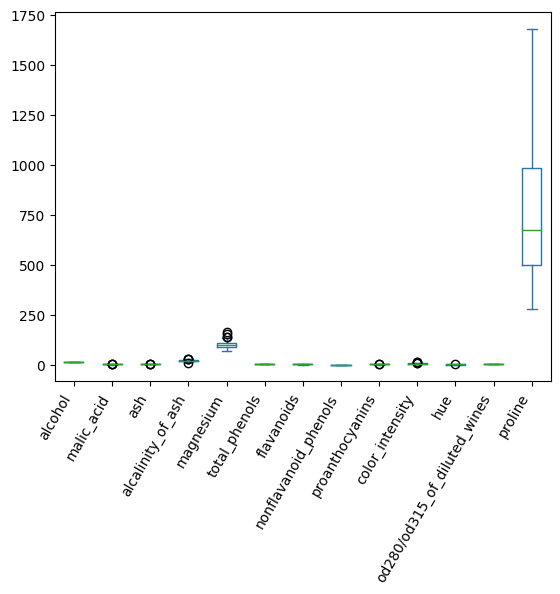

In [5]:
# Box plot 
df.plot.box()
plt.xticks(rotation=60, ha='right');

We were able to observe that there are outliers in some variables, but due to the difference in scale between the variables, it is difficult to compare them in a single plot.

An alternative here would be to plot separately. However, we can also choose to scale this data just for visualization using the `scale` function imported from the `sklearn.preprocessing` library:

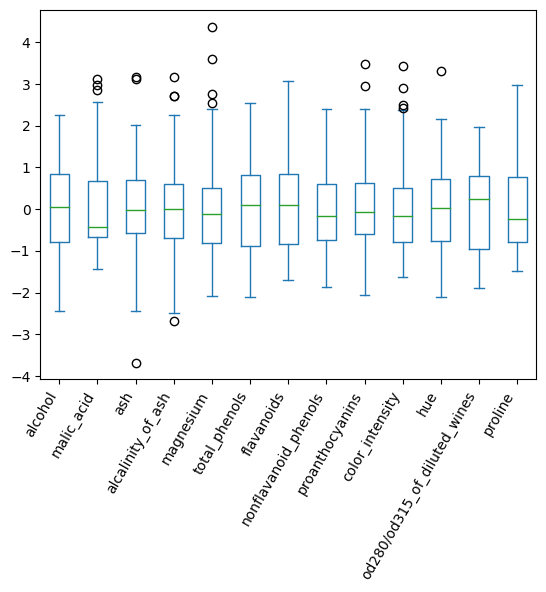

In [6]:
df.apply(scale).plot.box()
plt.xticks(rotation=60, ha='right');

We verified that there are outliers, so the next step would be to identify them to verify if it makes sense or not. For this, we would discuss with the business team (in this case, a wine specialist).

## Interquartile range

$$
\text{lower_outlier} = Q1 - 1.5 \times IQR
$$
$$
\text{upper_outlier} = Q3 + 1.5 \times IQR
$$

where $Q1$ represents the first quartile, $Q3$ the third, and $IQR$ the interquartile range.

In [8]:
def is_outlier(array, extreme=False):
  """Custom function to identify outliers in an array"""
  q1,q3 = np.quantile(array, [.25,.75])
  iqr = q3-q1
  
  factor = 3. if extreme else 1.5
  upper_outlier = q3 + factor*iqr
  lower_outlier = q1 - factor*iqr

  return (array < lower_outlier) | (array > upper_outlier)

The function returns a boolean array of the same size as the input array, indicating whether or not the value is an outlier:

In [9]:
is_outlier(df.ash)

0      False
1      False
2      False
3      False
4      False
       ...  
173    False
174    False
175    False
176    False
177    False
Name: ash, Length: 178, dtype: bool

In [11]:
# Calculating number of outliers
is_outlier(df.ash).sum()

3

E podemos aplicá-la para uma ou mais colunas através do método `apply`:

In [12]:
# Showing function application for all continuous numeric columns
df.apply(is_outlier)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,False,True,False,False,False,False,False,False,False,False,False,False,False
174,False,False,False,False,False,False,False,False,False,False,False,False,False
175,False,False,False,False,False,False,False,False,False,False,False,False,False
176,False,False,False,False,False,False,False,False,False,False,False,False,False


In [14]:
# Calculating number of outliers
df.apply(is_outlier).sum()

alcohol                         0
malic_acid                      3
ash                             3
alcalinity_of_ash               4
magnesium                       4
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 2
color_intensity                 4
hue                             1
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64

In [ ]:
# Removendo outliers
df[~df.apply(is_outlier).any(axis=1)]

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,14.16,2.51,2.48,20.0,91.0,1.68,0.70,0.44,1.24,9.70,0.62,1.71,660.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


### And we can compare the distributions with or without outlier removal:

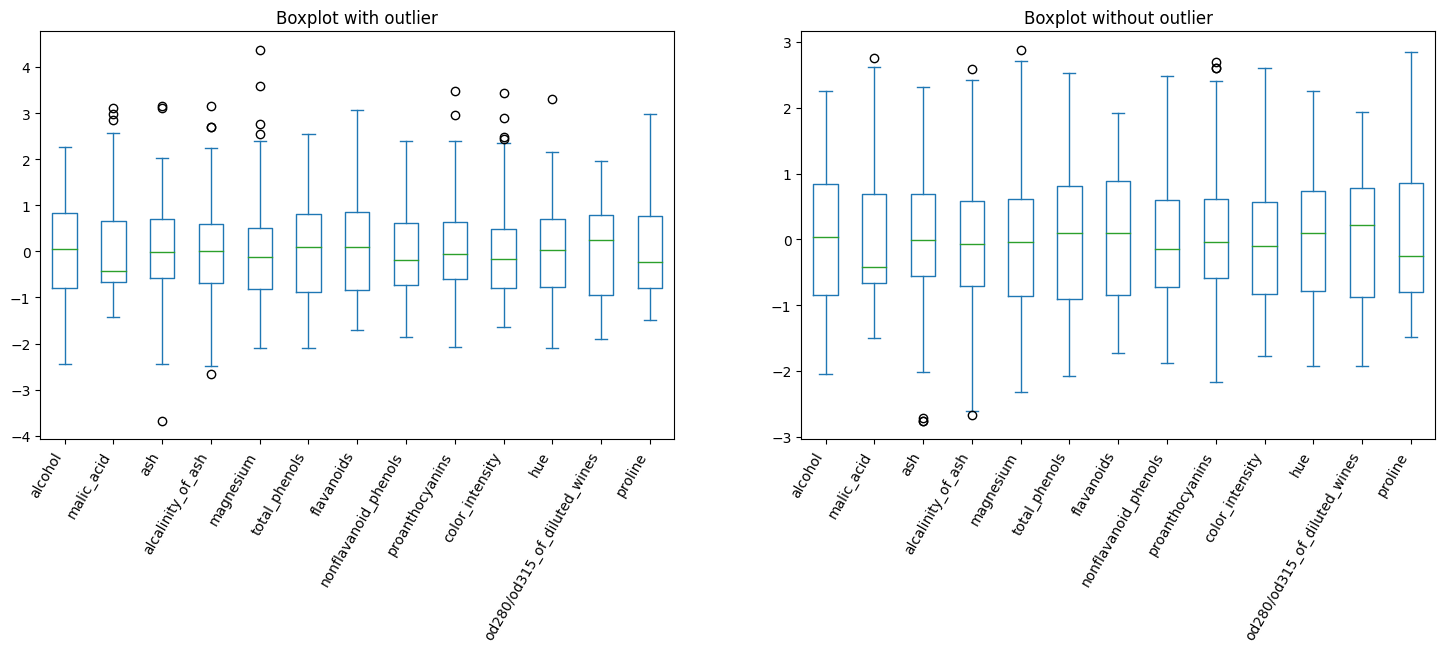

In [16]:
# Side-by-side figure of original and standardized data

df_without_outliers = df[~df.apply(is_outlier).any(axis=1)]

fig,axes = plt.subplots(ncols=2, figsize=(18,6))

df.apply(scale).plot.box(ax=axes[0], title='Boxplot with outlier')
df_without_outliers.apply(scale).plot.box(ax=axes[1], title='Boxplot without outlier')

fig.autofmt_xdate(rotation=60, ha='right')
plt.show()

In [17]:
df_without_outliers.apply(is_outlier).sum()

alcohol                         0
malic_acid                      1
ash                             3
alcalinity_of_ash               2
magnesium                       1
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 3
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64

When we add or remove values, we end up modifying the data distribution, especially values that are farther from the center of the distribution. Therefore, removing outliers does not necessarily guarantee that there will be no more outliers in the new distribution.

## Z-score

In [ ]:
def zscore_outlier(array):
  scaled_array = scale(array)
  return (scaled_array<-3) | (scaled_array>3)

df_without_outliers = df[~df.apply(zscore_outlier).any(axis=1)]

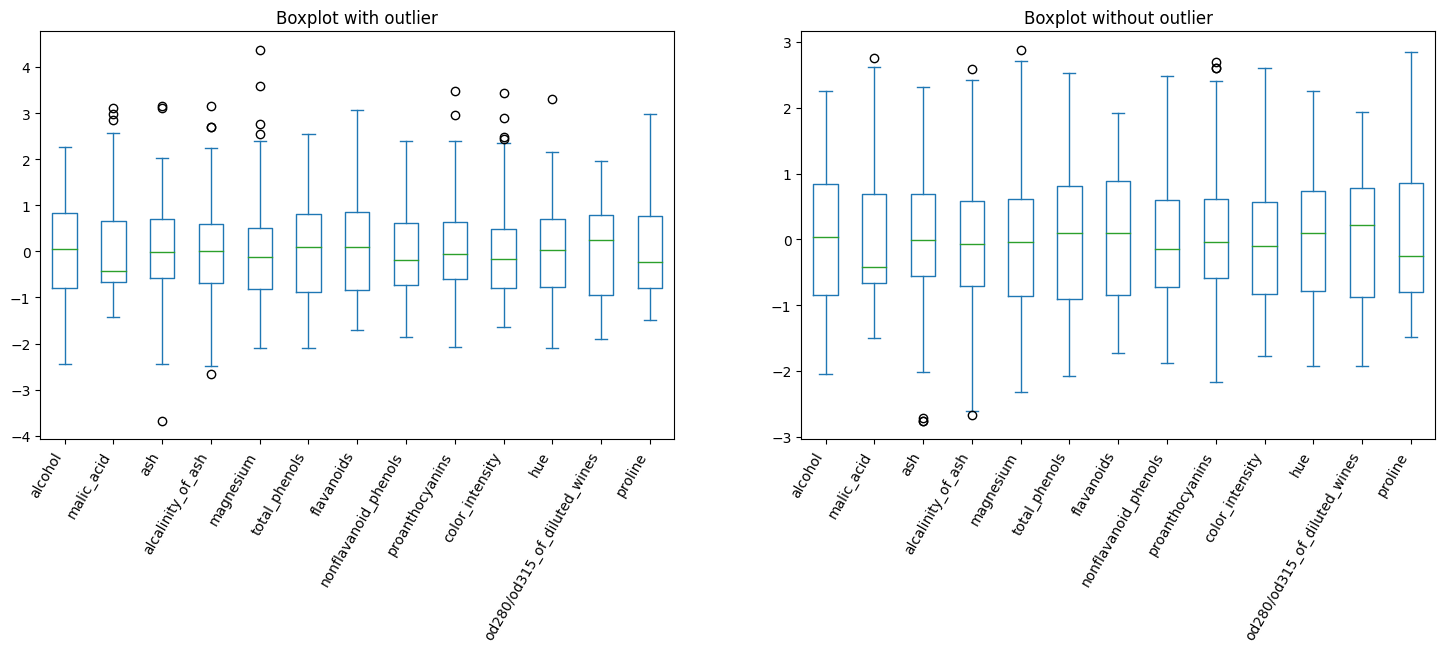

In [19]:
# Side-by-side figure of original and standardized data highlighting 3 std

fig,axes = plt.subplots(ncols=2, figsize=(18,6))

df.apply(scale).plot.box(ax=axes[0], title='Boxplot with outlier')
df_without_outliers.apply(scale).plot.box(ax=axes[1], title='Boxplot without outlier')

fig.autofmt_xdate(rotation=60, ha='right')
plt.show()

## Cap
replacing all values that are greater than the 99th percentile (i.e. top 1% of values) with the 99th percentile value. %.

In [20]:
df.describe(percentiles=[.01, .25, .5, .75, .9, .99])

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
1%,11.440800,0.897700,1.700000,11.354000,78.000000,1.138500,0.470000,0.140000,0.420000,1.863200,0.547700,1.290000,306.940000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
90%,14.100000,3.983000,2.700000,24.000000,118.000000,3.044000,3.233000,0.530000,2.305000,8.530000,1.233000,3.456000,1261.500000
99%,14.472800,5.542200,2.989000,28.500000,141.760000,3.595900,3.791400,0.630000,3.033600,11.018500,1.426900,3.843000,1522.360000


In [21]:
def cap_values(array, lower_quantile=0., upper_quantile=1.):
  array = array.copy()
  
  lower_quantile = np.quantile(array, lower_quantile)
  upper_quantile = np.quantile(array, upper_quantile)
  
  array[array<lower_quantile] = lower_quantile
  array[array>upper_quantile] = upper_quantile
  
  return array

In [23]:
# Showing percentiles after applying function
cap_values(df.ash, upper_quantile=.90).max()

2.7

In [ ]:
df.apply(cap_values, upper_quantile=.99).describe(percentiles=[.01, .25, .5, .75, .9, .99])

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,12.997054,2.334294,2.363865,19.486517,99.575955,2.292089,2.021252,0.361685,1.586445,5.042848,0.955729,2.610371,745.869213
std,0.804575,1.111002,0.267036,3.314706,13.680946,0.618829,0.979667,0.124067,0.559125,2.272948,0.223969,0.707571,312.129198
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
1%,11.440800,0.897700,1.700000,11.354000,78.000000,1.138500,0.470000,0.140000,0.420000,1.863200,0.547700,1.290000,306.940000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
90%,14.100000,3.983000,2.700000,24.000000,118.000000,3.044000,3.233000,0.530000,2.305000,8.530000,1.233000,3.456000,1261.500000
99%,14.409044,5.517406,2.935870,28.500000,139.634800,3.537457,3.759522,0.630000,2.976928,10.850255,1.421587,3.825290,1516.692800


## Log Transformation

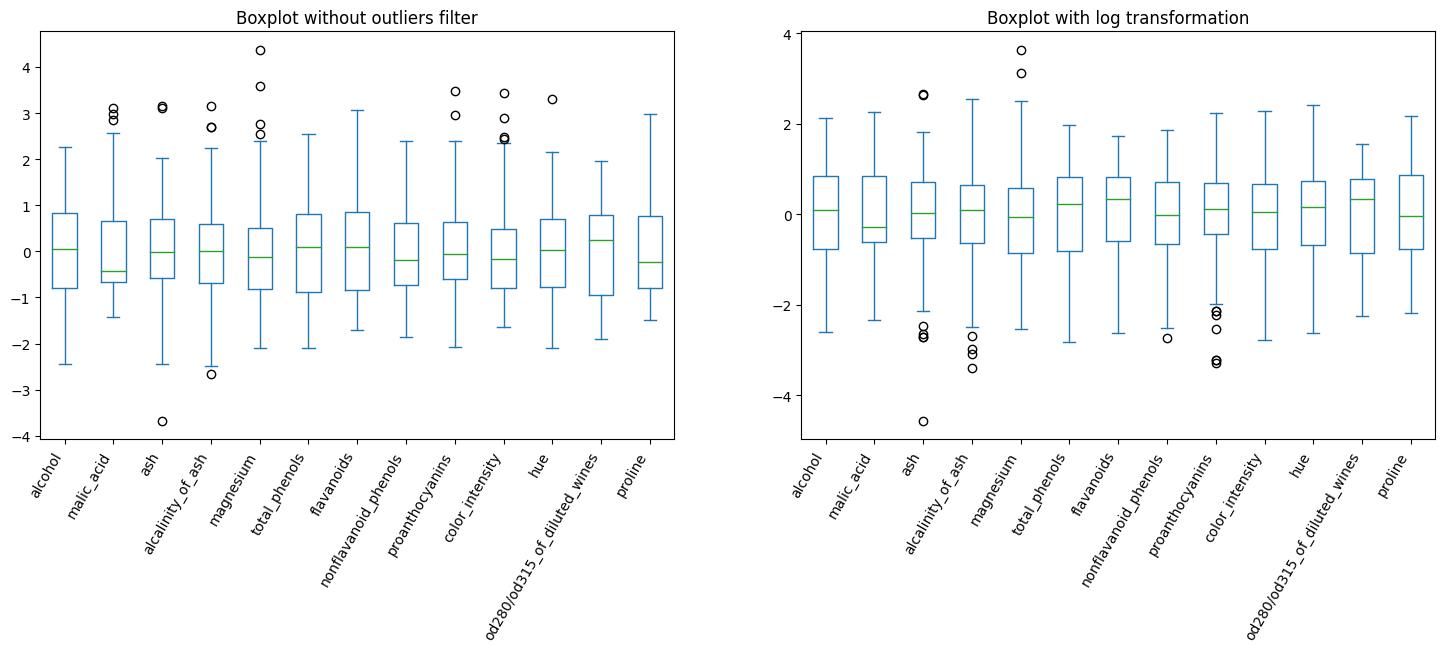

In [25]:
fig,axes = plt.subplots(ncols=2, figsize=(18,6))

df.apply(scale).plot.box(ax=axes[0], title='Boxplot without outliers filter')
df.apply(np.log).apply(scale).plot.box(ax=axes[1], title='Boxplot with log transformation')

fig.autofmt_xdate(rotation=60, ha='right')
plt.show()

### Box-cox

In [26]:
from sklearn.preprocessing import power_transform

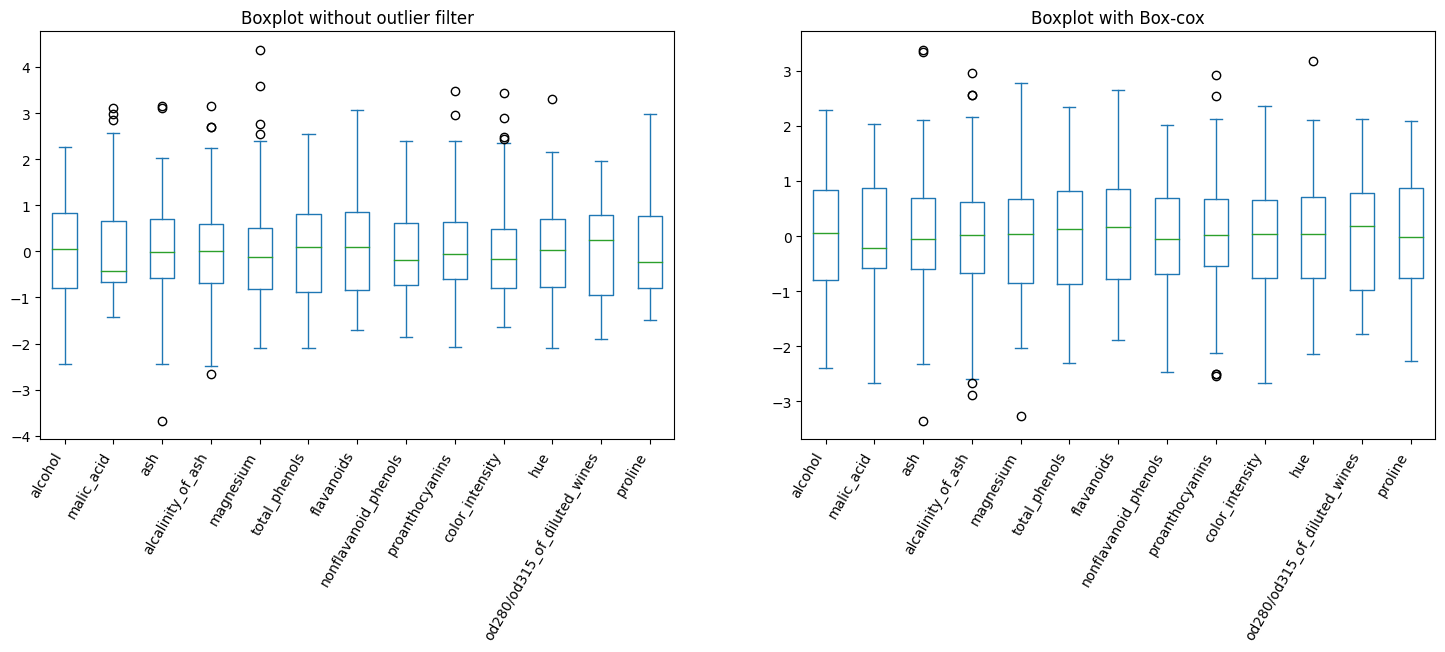

In [27]:
df_boxbox = pd.DataFrame(power_transform(df, method='box-cox'), columns=df.columns)

fig,axes = plt.subplots(ncols=2, figsize=(18,6))

df.apply(scale).plot.box(ax=axes[0], title='Boxplot without outlier filter')
df_boxbox.plot.box(ax=axes[1], title='Boxplot with Box-cox')

fig.autofmt_xdate(rotation=60, ha='right')
plt.show()